## Libraries & Configuration

In [26]:
%matplotlib widget
# Libraries
import numpy as np
import math
from scipy.linalg import block_diag
from matplotlib import pyplot as plt
import copy
from mpl_toolkits import mplot3d

# Configurations
# %matplotlib qt
plt.rcParams['figure.figsize']=[15,15]


## Function Declarations

In [2]:
# Transformation rules for adjacency matrix, Z

def transform_Z(symplectic, Z):
    A = symplectic[:int(np.shape(symplectic)[0]/2),:int(np.shape(symplectic)[0]/2)]
    B = symplectic[int(np.shape(symplectic)[0]/2):,:int(np.shape(symplectic)[0]/2)]
    C = symplectic[:int(np.shape(symplectic)[0]/2),int(np.shape(symplectic)[0]/2):]
    D = symplectic[int(np.shape(symplectic)[0]/2):,int(np.shape(symplectic)[0]/2):]

    return (C + D@Z)@np.linalg.inv(A + B@Z)

In [3]:
# Mode transformation from H-graph into Approximate CV Cluster state

def identify_bipartition(Z):
    modes = list(np.arange(int(np.shape(Z)[0])))
    for mode in modes:
        test_modes = copy.deepcopy(modes)
        test_modes.remove(mode)
        for test_mode in test_modes:
            if abs(Z[mode][test_mode]) > 0.1 or abs(Z[test_mode][mode]) > 0.1:
                modes.remove(test_mode)
    return modes

def generate_S_h2c(modes):
    S_h2c = np.identity(num_modes*4)
    for mode in modes:
        S_h2c[mode][mode] = 0
        S_h2c[mode][mode+2*num_modes] = -1
        S_h2c[mode+2*num_modes][mode] = 1
        S_h2c[mode+2*num_modes][mode+2*num_modes] = 0

    return S_h2c

In [4]:
# Symplectic matrix for EPR state generation from two initially squeezed modes

def epr_symplectic():

    #Delay on B mode

    S_phase_delay = np.zeros((num_modes*4, num_modes*4))

    for i in range(num_modes):
        S_phase_delay[i*2,i*2] = 1
        S_phase_delay[(num_modes+i)*2,(num_modes+i)*2] = 1
        S_phase_delay[i*2+1,(num_modes+i)*2+1] = -1
        S_phase_delay[(num_modes+i)*2+1,i*2+1] = 1

    #Beamsplitter for EPR state generation

    S_bs0 = np.array([])

    for i in range(num_modes):
        bs_block = np.array([[1/np.sqrt(2),-1/np.sqrt(2)],[1/np.sqrt(2),1/np.sqrt(2)]])
        if i == 0:
            S_bs0 = np.block([
                [bs_block, np.zeros((2,2))],
                [np.zeros((2,2)), bs_block]
            ])
        else:
            size = np.shape(S_bs0)
            S_bs0 = np.block([
                [S_bs0[:int(size[0]/2),:int(size[0]/2)],np.zeros((int(size[1]/2),2)), S_bs0[int(size[0]/2):,:int(size[0]/2)],np.zeros((int(size[1]/2),2))],
                [np.zeros((2,int(size[0]/2))), bs_block, np.zeros((2,int(size[0]/2))), np.zeros((2,2))],
                [S_bs0[int(size[0]/2):,:int(size[0]/2)], np.zeros((int(size[1]/2),2)), S_bs0[int(size[0]/2):,int(size[0]/2):], np.zeros((int(size[1]/2),2))],
                [np.zeros((2,int(size[0]/2))), np.zeros((2,2)), np.zeros((2,int(size[0]/2))), bs_block]
            ])

    return S_bs0@S_phase_delay

In [5]:
# Symplectic matrix for cluster state generation from an EPR state

def cluster_symplectic(bs_1=0, bs_2=0, bs_3=0):

    #Beamsplitter for 1D cluster generation

    if bs_1 == 0:

        S_bs1 = np.diag(np.ones(num_modes*4))

    else:

        bs1_block = np.diag(np.ones(num_modes*2))

        for i in range(num_modes):
            if 2*i+1+(2*bs_1-1) < num_modes*2:
                bs1_block[2*i+1,2*i+1] = 1/np.sqrt(2)
                bs1_block[2*i+1,2*i+1+(2*bs_1-1)] = -1/np.sqrt(2)
                bs1_block[2*i+1+(2*bs_1-1),2*i+1] = 1/np.sqrt(2)
                bs1_block[2*i+1+(2*bs_1-1),2*i+1+(2*bs_1-1)] = 1/np.sqrt(2)

        S_bs1 = np.block([[bs1_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs1_block]]) 

    #Beamsplitter for 2D cluster generation

    if bs_2 == 0:

        S_bs2 = np.diag(np.ones(num_modes*4))

    else:

        bs2_block = np.diag(np.ones(num_modes*2))

        for i in range(num_modes):
            if 2*i+1+(2*bs_2-1) < num_modes*2:
                bs2_block[2*i+1,2*i+1] = 1/np.sqrt(2)
                bs2_block[2*i+1,2*i+1+(2*bs_2-1)] = -1/np.sqrt(2)
                bs2_block[2*i+1+(2*bs_2-1),2*i+1] = 1/np.sqrt(2)
                bs2_block[2*i+1+(2*bs_2-1),2*i+1+(2*bs_2-1)] = 1/np.sqrt(2)

        S_bs2 = np.block([[bs2_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs2_block]])  

    #Beamsplitter for 3D cluster generation

    if bs_3 == 0:

        S_bs3 = np.diag(np.ones(num_modes*4))
    
    else:

        bs3_block = np.diag(np.ones(num_modes*2))

        for i in range(num_modes):
            if 2*i+1+(2*bs_3-1) < num_modes*2:
                bs3_block[2*i+1,2*i+1] = 1/np.sqrt(2)
                bs3_block[2*i+1,2*i+1+(2*bs_3-1)] = -1/np.sqrt(2)
                bs3_block[2*i+1+(2*bs_3-1),2*i+1] = 1/np.sqrt(2)
                bs3_block[2*i+1+(2*bs_3-1),2*i+1+(2*bs_3-1)] = 1/np.sqrt(2)

        S_bs3 = np.block([[bs3_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs3_block]]) 

    return S_bs3@S_bs2@S_bs1

In [6]:
def measure_nodes(nodes, Z):
    for node in nodes:
        for i in range(np.shape(Z)[0]):
            Z[node][i] = 0
            Z[i][node] = 0

    return Z

In [7]:
def rotate_node(mode, angle, Z):
    
    S_rot = np.diag(np.ones(num_modes*4))
    S_rot[mode][mode] = np.cos(angle)
    S_rot[mode+2*num_modes][mode+2*num_modes] = np.cos(angle)
    S_rot[mode][mode+2*num_modes] = np.sin(angle)
    S_rot[mode+2*num_modes][mode] = -np.sin(angle)

    return  transform_Z(S_rot, Z)

## Plotting Tools

In [8]:
# Coordinates for A & B modes aligned in time

def get_coordinate(i):
    is_odd = i % 2
    i = math.floor(i/2)
    y = math.floor(i/bs_3) + 0.3*is_odd
    i = i % bs_3
    z = math.floor(i/(bs_2))
    x = i % (bs_2)
    return [x,y,z]

# Coordinates for A & B modes skewed in time (B modes shifted by one time delay)

def get_coordinate_skewed(i):
    is_odd = i % 2
    i = math.floor(i/2)
    y = math.floor(i/bs_3) + 0.3*is_odd
    i = i % bs_3
    z = math.floor(i/(bs_2))
    x = i % (bs_2)+1*is_odd
    return [x,y,z]

def get_coordinate_skewed_2(i):
    is_odd = i % 2
    i = math.floor(i/2)
    y = math.floor(i/bs_3) + 0.3*is_odd
    i = i % bs_3
    z = math.floor(i/(bs_2))+1*is_odd
    x = i % (bs_2)+1*is_odd
    return [x,y,z]    

# Draw lines between mode coordinates

def draw_line(i,k,a,colour):
    a_coordinates = coordinates[i]
    b_coordinates = coordinates[k]
    ax.plot3D([a_coordinates[0],b_coordinates[0]],[a_coordinates[1],b_coordinates[1]],[a_coordinates[2],b_coordinates[2]], colour, alpha=a)

## Main Simulation

In [18]:
num_modes = 96*2
r = 2.5
bs_1, bs_2, bs_3 = 1, 8, 96

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z_0 = Z

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

Z3 = transform_Z(cluster_symplectic(bs_1, bs_2+1, bs_3+1+bs_2), Z)


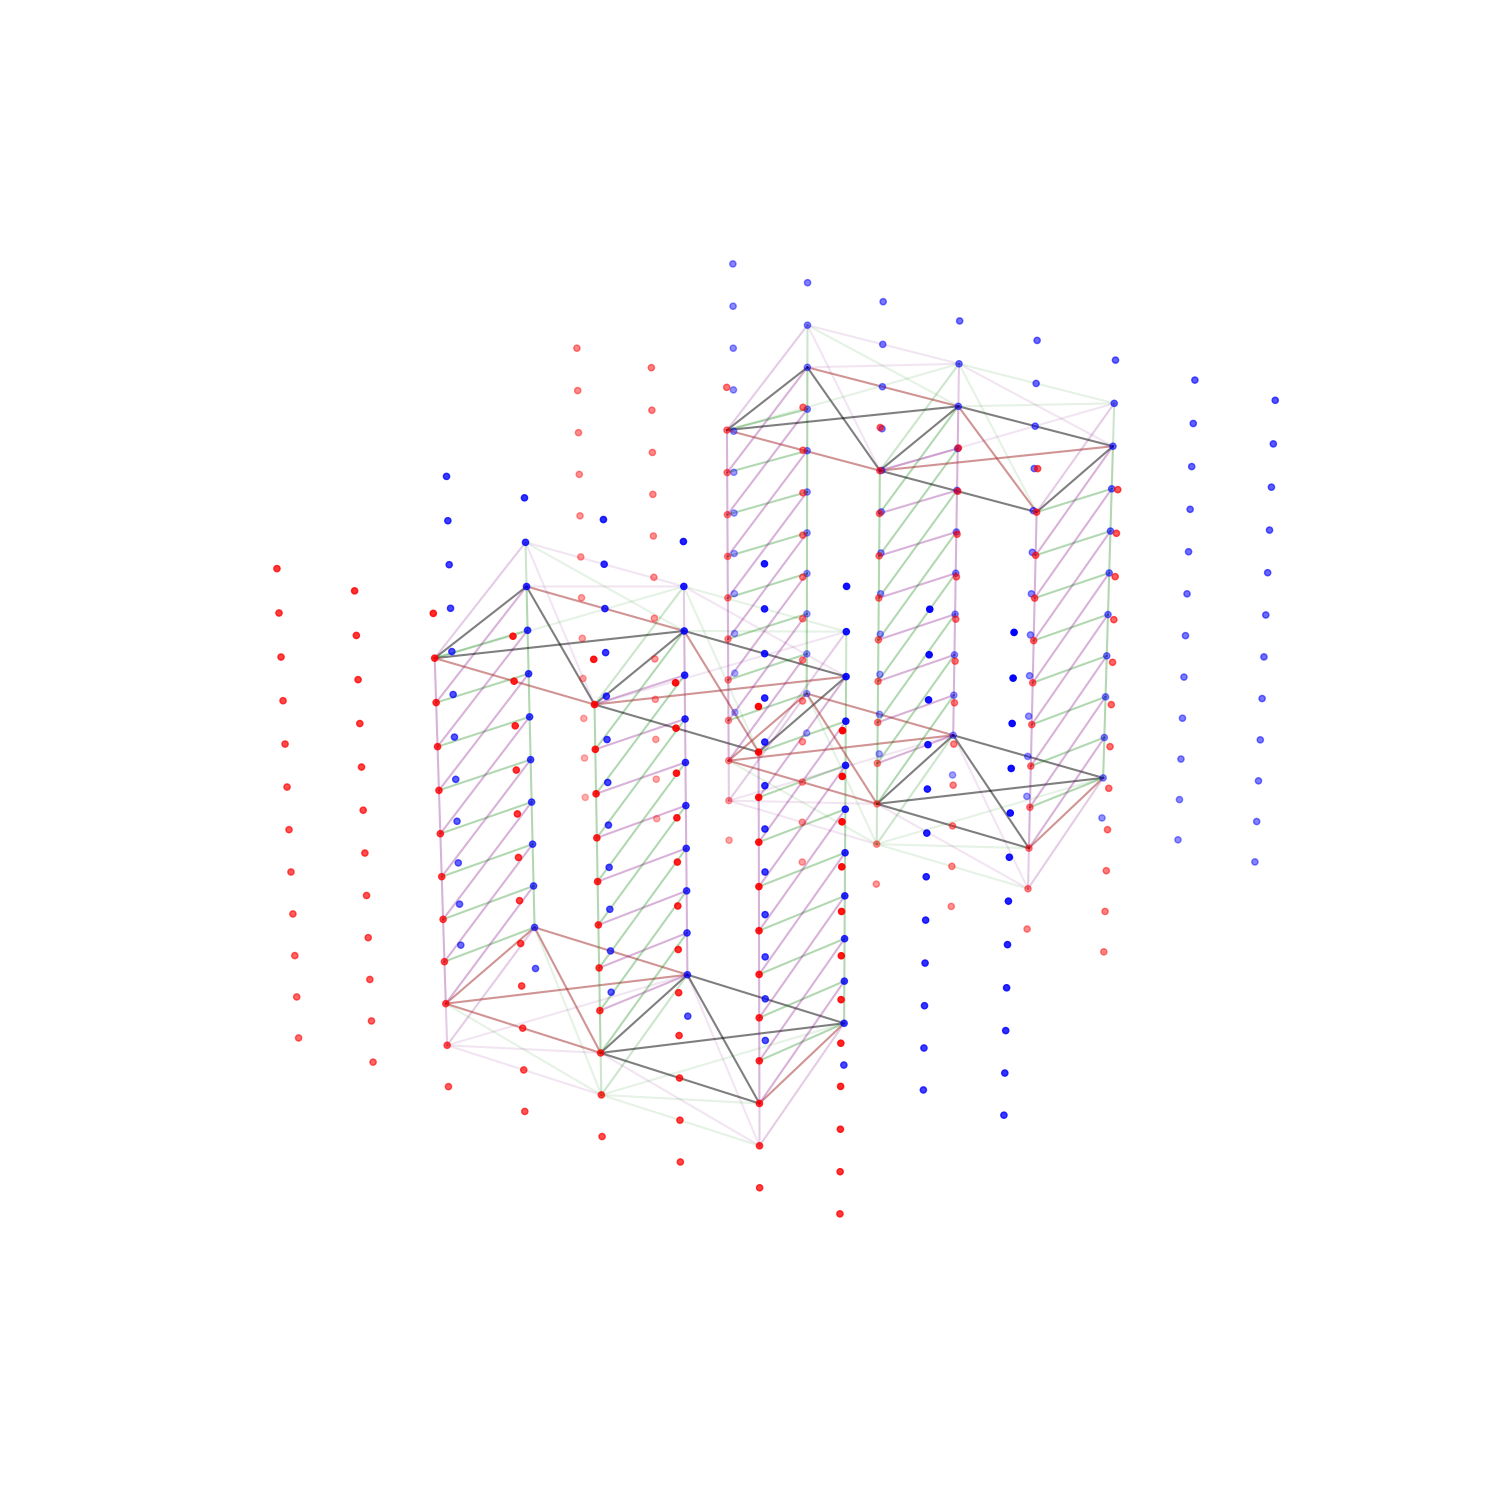

In [39]:
# Create figure
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.title('EPR')

#Remove grid lines and axis
plt.grid(b=None)
plt.axis('off')

#Define nodes
a_coord, b_coord = [], []
coordinates = np.array([get_coordinate_skewed_2(i) for i in range(num_modes*2)])

for i in range(len(coordinates)):
    if i%2 == 0:
        a_coord.append(list(coordinates[i]))
    else:
        b_coord.append(list(coordinates[i]))

a_coord, b_coord = np.array(a_coord), np.array(b_coord)

ax.scatter3D(a_coord[:,0], a_coord[:,1], a_coord[:,2], color='red')
ax.scatter3D(b_coord[:,0], b_coord[:,1], b_coord[:,2], color='blue')
ax.set_xlabel('x')
ax.axes.set_xlim3d(left=0, right=8)
ax.axes.set_ylim3d(bottom=0, top=1.3) 
ax.axes.set_zlim3d(bottom=0, top=11) 

cov = Z2

pi4_rotation_nodes = [17,18,33,34,49,50,65,66,81,82,97,98,113,114,25,26,41,42,57,58,73,74,89,90,105,106,121,122,129,130,137,138,161,162,145,146,169,170,153,154]

pi4_rotation_nodes_second_layer = [i + bs_3*2 for i in pi4_rotation_nodes]

minus_pi4_rotation_modes = [21,22,37,38,53,54,69,70,85,86,101,102,117,118,29,30,45,46,61,62,77,78,93,94,109,110,125,126,133,134,141,142,165,166,149,150,173,174,157,158]

minus_pi4_rotation_modes_second_layer = [i + bs_3*2 for i in minus_pi4_rotation_modes]

for mode in pi4_rotation_nodes:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in minus_pi4_rotation_modes:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in pi4_rotation_nodes_second_layer:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in minus_pi4_rotation_modes_second_layer:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# remove side edges (1D)
side_nodes = [0,15,16,31,32,47,48,63,64,79,80,95,96,111,112,127,128,143,144,159,160,175,176,191]
cov = measure_nodes(side_nodes, cov)
cov = measure_nodes([i+bs_3*2 for i in side_nodes], cov)

# # remove top and bottom layers (1D)
cov = measure_nodes(range(1,15), cov)
cov = measure_nodes(range(177,191), cov)

cov = measure_nodes(range(193,207), cov)
cov = measure_nodes(range(369,383), cov)

rotation_nodes_pi4 = [148,131,84,67,152,135,88,71,156,139,92,75]
rotation_nodes_minus_pi4 = [116,99,52,35,120,103,56,39,124,107,60,43]

rotation_nodes_pi4_second_layer = [i + bs_3*2 for i in rotation_nodes_pi4]
rotation_nodes_minus_pi4_second_layer = [i + bs_3*2 for i in rotation_nodes_minus_pi4]

for mode in rotation_nodes_pi4:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in rotation_nodes_minus_pi4:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in rotation_nodes_pi4_second_layer:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in rotation_nodes_minus_pi4_second_layer:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# remove top and bottom layers (2D)
cov = measure_nodes([19,20,36,23,24,40,27,28,44], cov)
cov = measure_nodes([163,164,147,167,168,151,171,172,155], cov)

cov = measure_nodes([211, 212, 228, 215, 216, 232, 219, 220, 236], cov)
cov = measure_nodes([355, 356, 339, 359, 360, 343, 363, 364, 347], cov)

# cov = np.real(cov)

# for i in range(np.shape(cov)[0]):
#     for j in range(np.shape(cov)[1]):
#         if abs(cov[i][j]) < 1e-3*np.tanh(2*r):
#             cov[i][j] = 0

# np.savetxt('check.csv', cov/np.tanh(2*r), delimiter=',')

offset = 0.01


for i in range(num_modes*2):
    for k in range(i+1, num_modes*2):
        if cov[i][k]>(1-offset) and cov[i][k]<(1+offset):
            #weight is tanh(2r) 
            draw_line(i,k,0.5,'purple')

        elif cov[i][k]<-(1-offset) and cov[i][k]>-(1+offset):
            #weight is -tanh(2r)
            draw_line(i,k,0.5,'green')

        elif cov[i][k]>0.5*(1-offset) and cov[i][k]<0.5*(1+offset):
            #weight is 1/2*tanh(2r)
            draw_line(i,k,0.3,'purple')

        elif cov[i][k]<-0.5*(1-offset) and cov[i][k]>-0.5*(1+offset):
            #weight is -1/2*tanh(2r)
            draw_line(i,k,0.3,'green')

        elif cov[i][k]<-(1/np.sqrt(2))*(1-offset) and cov[i][k]>-(1/np.sqrt(2))*(1+offset):
            #weight is -1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'green')

        elif cov[i][k]>(1/np.sqrt(2))*(1-offset) and cov[i][k]<(1/np.sqrt(2))*(1+offset):
            #weight is 1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'purple')

        elif cov[i][k]<-(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]>-(1/(2*np.sqrt(2)))*(1+offset):
            #weight is -1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'green')

        elif cov[i][k]>(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(2*np.sqrt(2)))*(1+offset):
            #weight is 1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'purple')

        elif cov[i][k]>(1/4)*(1-offset) and cov[i][k]<(1/4)*(1+offset):
            #weight is 1/4*tanh(2r)
            draw_line(i,k,0.2,'purple')

        elif cov[i][k]<(-1/4)*(1-offset) and cov[i][k]>(-1/4)*(1+offset):
            #weight is -1/4*tanh(2r)
            draw_line(i,k,0.2,'green')

        elif cov[i][k]>(1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(4*np.sqrt(2)))*(1+offset):
            #weight is 1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'purple')

        elif cov[i][k]<(-1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]>(-1/(4*np.sqrt(2)))*(1+offset):
            #weight is -1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'green')

        elif cov[i][k]>(1/8)*(1-offset) and cov[i][k]<(1/8)*(1+offset):
            #weight is 1/8*tanh(2r)
            draw_line(i,k,0.1,'purple')

        elif cov[i][k]<(-1/8)*(1-offset) and cov[i][k]>(-1/8)*(1+offset):
            #weight is -1/8*tanh(2r)
            draw_line(i,k,0.1,'green')

        elif abs(cov[i][k])>0.001:
            if cov[i][k] < 0:
                draw_line(i,k,0.5,'brown')
            else:
                draw_line(i,k,0.5,'black')



In [12]:
plt.matshow(cov/np.tanh(2*r))
plt.colorbar

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

## Noise Analysis

In [171]:
num_modes = 24
r = 0.69
r = 2.5
bs_1, bs_2, bs_3 = 1, 4, 24

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [190]:
# Create figure
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.title('EPR')

#Remove grid lines and axis
plt.grid(b=None)
plt.axis('off')

#Define nodes
a_coord, b_coord = [], []
coordinates = np.array([get_coordinate_skewed_2(i) for i in range(num_modes*2)])

for i in range(len(coordinates)):
    if i%2 == 0:
        a_coord.append(list(coordinates[i]))
    else:
        b_coord.append(list(coordinates[i]))

a_coord, b_coord = np.array(a_coord), np.array(b_coord)

ax.scatter3D(a_coord[:,0], a_coord[:,1], a_coord[:,2], color='red')
ax.scatter3D(b_coord[:,0], b_coord[:,1], b_coord[:,2], color='blue')
ax.set_xlabel('x')
ax.axes.set_xlim3d(left=0, right=4)
ax.axes.set_ylim3d(bottom=0, top=0.3) 
ax.axes.set_zlim3d(bottom=0, top=6) 

cov = Z2

# remove side edges (1D)
side_nodes = [0,7,8,15,16,23,24,31,32,39,40,47]
cov = measure_nodes(side_nodes, cov)

# remove top and bottom layers (1D)
cov = measure_nodes(range(1,7), cov)
cov = measure_nodes(range(40,47), cov)

pi4_rotation_nodes = [9,10,17,18,25,26,33,34]

minus_pi4_rotation_modes = [13,14,21,22,29,30,37,38]

for mode in pi4_rotation_nodes:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in minus_pi4_rotation_modes:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# remove top and bottom layers (2D)
cov = measure_nodes([12,35], cov)

rotation_nodes_pi4 = [20,11]
rotation_nodes_minus_pi4 = [36,27]

for mode in rotation_nodes_pi4:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in rotation_nodes_minus_pi4:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# cov = np.real(cov)

# for i in range(np.shape(cov)[0]):
#     for j in range(np.shape(cov)[1]):
#         if abs(cov[i][j]) < 1e-3*np.tanh(2*r):
#             cov[i][j] = 0

np.savetxt('check.csv', cov/np.tanh(2*r), delimiter=',')

offset = 0.01

for i in range(num_modes*2):
    for k in range(i+1, num_modes*2):
        if cov[i][k]>(1-offset) and cov[i][k]<(1+offset):
            #weight is tanh(2r) 
            draw_line(i,k,0.5,'purple')

        elif cov[i][k]<-(1-offset) and cov[i][k]>-(1+offset):
            #weight is -tanh(2r)
            draw_line(i,k,0.5,'green')

        elif cov[i][k]>0.5*(1-offset) and cov[i][k]<0.5*(1+offset):
            #weight is 1/2*tanh(2r)
            draw_line(i,k,0.3,'purple')

        elif cov[i][k]<-0.5*(1-offset) and cov[i][k]>-0.5*(1+offset):
            #weight is -1/2*tanh(2r)
            draw_line(i,k,0.3,'green')

        elif cov[i][k]<-(1/np.sqrt(2))*(1-offset) and cov[i][k]>-(1/np.sqrt(2))*(1+offset):
            #weight is -1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'green')

        elif cov[i][k]>(1/np.sqrt(2))*(1-offset) and cov[i][k]<(1/np.sqrt(2))*(1+offset):
            #weight is 1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'purple')

        elif cov[i][k]<-(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]>-(1/(2*np.sqrt(2)))*(1+offset):
            #weight is -1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'green')

        elif cov[i][k]>(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(2*np.sqrt(2)))*(1+offset):
            #weight is 1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'purple')

        elif cov[i][k]>(1/4)*(1-offset) and cov[i][k]<(1/4)*(1+offset):
            #weight is 1/4*tanh(2r)
            draw_line(i,k,0.2,'purple')

        elif cov[i][k]<(-1/4)*(1-offset) and cov[i][k]>(-1/4)*(1+offset):
            #weight is -1/4*tanh(2r)
            draw_line(i,k,0.2,'green')

        elif cov[i][k]>(1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(4*np.sqrt(2)))*(1+offset):
            #weight is 1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'purple')

        elif cov[i][k]<(-1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]>(-1/(4*np.sqrt(2)))*(1+offset):
            #weight is -1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'green')

        elif cov[i][k]>(1/8)*(1-offset) and cov[i][k]<(1/8)*(1+offset):
            #weight is 1/8*tanh(2r)
            draw_line(i,k,0.1,'purple')

        elif cov[i][k]<(-1/8)*(1-offset) and cov[i][k]>(-1/8)*(1+offset):
            #weight is -1/8*tanh(2r)
            draw_line(i,k,0.1,'green')

        elif abs(cov[i][k])>0.001:
            if cov[i][k] < 0:
                draw_line(i,k,0.5,'brown')
            else:
                draw_line(i,k,0.5,'black')


In [319]:
num_modes = 4
r = 0.69
r = 2.5
bs_1, bs_2, bs_3 = 1, 4, 24

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [320]:
# Create figure
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.title('EPR')

#Remove grid lines and axis
plt.grid(b=None)
plt.axis('off')

#Define nodes
a_coord, b_coord = [], []
coordinates = np.array([get_coordinate_skewed(i) for i in range(num_modes*2)])

for i in range(len(coordinates)):
    if i%2 == 0:
        a_coord.append(list(coordinates[i]))
    else:
        b_coord.append(list(coordinates[i]))

a_coord, b_coord = np.array(a_coord), np.array(b_coord)

ax.scatter3D(a_coord[:,0], a_coord[:,1], a_coord[:,2], color='red')
ax.scatter3D(b_coord[:,0], b_coord[:,1], b_coord[:,2], color='blue')
ax.set_xlabel('x')
ax.axes.set_xlim3d(left=0, right=bs_2)
ax.axes.set_ylim3d(bottom=0, top=0.3) 
ax.axes.set_zlim3d(bottom=0, top=6) 

cov = Z1

# remove side edges (1D)
side_nodes = [0,7]
cov = measure_nodes(side_nodes, cov)

# # remove top and bottom layers (1D)
# cov = measure_nodes(range(1,7), cov)
# cov = measure_nodes(range(40,47), cov)

pi4_rotation_nodes = [1,2]

minus_pi4_rotation_modes = [5,6]

for mode in pi4_rotation_nodes:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in minus_pi4_rotation_modes:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# remove top and bottom layers (2D)
# cov = measure_nodes([12,35], cov)

# rotation_nodes_pi4 = [20,11]
# rotation_nodes_minus_pi4 = [36,27]

# for mode in rotation_nodes_pi4:
#     cov = rotate_node(mode, np.pi/4, cov)
#     cov = measure_nodes([mode], cov)

# for mode in rotation_nodes_minus_pi4:
#     cov = rotate_node(mode, -np.pi/4, cov)
#     cov = measure_nodes([mode], cov)

# cov = np.real(cov)

# for i in range(np.shape(cov)[0]):
#     for j in range(np.shape(cov)[1]):
#         if abs(cov[i][j]) < 1e-3*np.tanh(2*r):
#             cov[i][j] = 0

np.savetxt('check.csv', cov/np.tanh(2*r), delimiter=',')

offset = 0.01

for i in range(num_modes*2):
    for k in range(i+1, num_modes*2):
        if cov[i][k]>(1-offset) and cov[i][k]<(1+offset):
            #weight is tanh(2r) 
            draw_line(i,k,0.5,'purple')

        elif cov[i][k]<-(1-offset) and cov[i][k]>-(1+offset):
            #weight is -tanh(2r)
            draw_line(i,k,0.5,'green')

        elif cov[i][k]>0.5*(1-offset) and cov[i][k]<0.5*(1+offset):
            #weight is 1/2*tanh(2r)
            draw_line(i,k,0.3,'purple')

        elif cov[i][k]<-0.5*(1-offset) and cov[i][k]>-0.5*(1+offset):
            #weight is -1/2*tanh(2r)
            draw_line(i,k,0.3,'green')

        elif cov[i][k]<-(1/np.sqrt(2))*(1-offset) and cov[i][k]>-(1/np.sqrt(2))*(1+offset):
            #weight is -1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'green')

        elif cov[i][k]>(1/np.sqrt(2))*(1-offset) and cov[i][k]<(1/np.sqrt(2))*(1+offset):
            #weight is 1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'purple')

        elif cov[i][k]<-(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]>-(1/(2*np.sqrt(2)))*(1+offset):
            #weight is -1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'green')

        elif cov[i][k]>(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(2*np.sqrt(2)))*(1+offset):
            #weight is 1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'purple')

        elif cov[i][k]>(1/4)*(1-offset) and cov[i][k]<(1/4)*(1+offset):
            #weight is 1/4*tanh(2r)
            draw_line(i,k,0.2,'purple')

        elif cov[i][k]<(-1/4)*(1-offset) and cov[i][k]>(-1/4)*(1+offset):
            #weight is -1/4*tanh(2r)
            draw_line(i,k,0.2,'green')

        elif cov[i][k]>(1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(4*np.sqrt(2)))*(1+offset):
            #weight is 1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'purple')

        elif cov[i][k]<(-1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]>(-1/(4*np.sqrt(2)))*(1+offset):
            #weight is -1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'green')

        elif cov[i][k]>(1/8)*(1-offset) and cov[i][k]<(1/8)*(1+offset):
            #weight is 1/8*tanh(2r)
            draw_line(i,k,0.1,'purple')

        elif cov[i][k]<(-1/8)*(1-offset) and cov[i][k]>(-1/8)*(1+offset):
            #weight is -1/8*tanh(2r)
            draw_line(i,k,0.1,'green')

        elif abs(cov[i][k])>0.001:
            if cov[i][k] < 0:
                draw_line(i,k,0.5,'brown')
            else:
                draw_line(i,k,0.5,'black')

## Double wire in 3D cluster (in x)

In [15]:
r = 0.69
r = 2.5
bs_1, bs_2, bs_3 = 1, 6, 6*6
num_modes = bs_3

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [16]:
# Create figure
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.title('EPR')

#Remove grid lines and axis
plt.grid(b=None)
plt.axis('off')

#Define nodes
a_coord, b_coord = [], []
coordinates = np.array([get_coordinate_skewed(i) for i in range(num_modes*2)])

for i in range(len(coordinates)):
    if i%2 == 0:
        a_coord.append(list(coordinates[i]))
    else:
        b_coord.append(list(coordinates[i]))

a_coord, b_coord = np.array(a_coord), np.array(b_coord)

ax.scatter3D(a_coord[:,0], a_coord[:,1], a_coord[:,2], color='red')
ax.scatter3D(b_coord[:,0], b_coord[:,1], b_coord[:,2], color='blue')
ax.set_xlabel('x')
ax.axes.set_xlim3d(left=0, right=bs_2)
ax.axes.set_ylim3d(bottom=0, top=0.3) 
ax.axes.set_zlim3d(bottom=0, top=6) 

cov = Z2

# remove side edges (1D)
side_nodes = [0,11,12,23,24,35,36,47,48,59,60,71]
cov = measure_nodes(side_nodes, cov)

# remove top and bottom layers (1D)
cov = measure_nodes(range(1,11), cov)
cov = measure_nodes(range(60,71), cov)

pi4_rotation_nodes = [14,13,21,22,25,26,33,34,37,38,45,46,49,50,57,58]

minus_pi4_rotation_modes = [18,17,29,30,41,42,53,54]

for mode in pi4_rotation_nodes:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in minus_pi4_rotation_modes:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# remove top and bottom layers (2D)
cov = measure_nodes([16,20,51,55], cov)

rotation_nodes_pi4 = [52,39,43,56]
rotation_nodes_minus_pi4 = [15,28,19,32]

for mode in rotation_nodes_pi4:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in rotation_nodes_minus_pi4:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# cov = np.real(cov)

# for i in range(np.shape(cov)[0]):
#     for j in range(np.shape(cov)[1]):
#         if abs(cov[i][j]) < 1e-3*np.tanh(2*r):
#             cov[i][j] = 0

np.savetxt('check.csv', cov/np.tanh(2*r), delimiter=',')

offset = 0.01

for i in range(num_modes*2):
    for k in range(i+1, num_modes*2):
        if cov[i][k]>(1-offset) and cov[i][k]<(1+offset):
            #weight is tanh(2r) 
            draw_line(i,k,0.5,'purple')

        elif cov[i][k]<-(1-offset) and cov[i][k]>-(1+offset):
            #weight is -tanh(2r)
            draw_line(i,k,0.5,'green')

        elif cov[i][k]>0.5*(1-offset) and cov[i][k]<0.5*(1+offset):
            #weight is 1/2*tanh(2r)
            draw_line(i,k,0.3,'purple')

        elif cov[i][k]<-0.5*(1-offset) and cov[i][k]>-0.5*(1+offset):
            #weight is -1/2*tanh(2r)
            draw_line(i,k,0.3,'green')

        elif cov[i][k]<-(1/np.sqrt(2))*(1-offset) and cov[i][k]>-(1/np.sqrt(2))*(1+offset):
            #weight is -1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'green')

        elif cov[i][k]>(1/np.sqrt(2))*(1-offset) and cov[i][k]<(1/np.sqrt(2))*(1+offset):
            #weight is 1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'purple')

        elif cov[i][k]<-(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]>-(1/(2*np.sqrt(2)))*(1+offset):
            #weight is -1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'green')

        elif cov[i][k]>(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(2*np.sqrt(2)))*(1+offset):
            #weight is 1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'purple')

        elif cov[i][k]>(1/4)*(1-offset) and cov[i][k]<(1/4)*(1+offset):
            #weight is 1/4*tanh(2r)
            draw_line(i,k,0.2,'purple')

        elif cov[i][k]<(-1/4)*(1-offset) and cov[i][k]>(-1/4)*(1+offset):
            #weight is -1/4*tanh(2r)
            draw_line(i,k,0.2,'green')

        elif cov[i][k]>(1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(4*np.sqrt(2)))*(1+offset):
            #weight is 1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'purple')

        elif cov[i][k]<(-1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]>(-1/(4*np.sqrt(2)))*(1+offset):
            #weight is -1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'green')

        elif cov[i][k]>(1/8)*(1-offset) and cov[i][k]<(1/8)*(1+offset):
            #weight is 1/8*tanh(2r)
            draw_line(i,k,0.1,'purple')

        elif cov[i][k]<(-1/8)*(1-offset) and cov[i][k]>(-1/8)*(1+offset):
            #weight is -1/8*tanh(2r)
            draw_line(i,k,0.1,'green')

        elif abs(cov[i][k])>0.001:
            if cov[i][k] < 0:
                draw_line(i,k,0.5,'brown')
            else:
                draw_line(i,k,0.5,'black')

In [17]:
np.shape(Z2)

(72, 72)

## Double in wire in 3D cluster (in y)

In [31]:
r = 0.69
r = 2.5
bs_1, bs_2, bs_3 = 1, 4, 4*8
num_modes = bs_3

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [38]:
# Create figure
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.title('EPR')

#Remove grid lines and axis
plt.grid(b=None)
plt.axis('off')

#Define nodes
a_coord, b_coord = [], []
coordinates = np.array([get_coordinate_skewed(i) for i in range(num_modes*2)])

for i in range(len(coordinates)):
    if i%2 == 0:
        a_coord.append(list(coordinates[i]))
    else:
        b_coord.append(list(coordinates[i]))

a_coord, b_coord = np.array(a_coord), np.array(b_coord)

ax.scatter3D(a_coord[:,0], a_coord[:,1], a_coord[:,2], color='red')
ax.scatter3D(b_coord[:,0], b_coord[:,1], b_coord[:,2], color='blue')
ax.set_xlabel('x')
ax.axes.set_xlim3d(left=0, right=bs_2)
ax.axes.set_ylim3d(bottom=0, top=0.3) 
ax.axes.set_zlim3d(bottom=0, top=6) 

cov = Z2

# remove side edges (1D)
side_nodes = [0,7,8,15,16,23,24,31,32,39,40,47,48,55,56,63]
cov = measure_nodes(side_nodes, cov)

# remove top and bottom layers (1D)
cov = measure_nodes(range(1,7), cov)
cov = measure_nodes(range(57,63), cov)

pi4_rotation_nodes = [9,10,17,18,25,26,33,34,41,42,49,50]

minus_pi4_rotation_modes = [13,14,21,22,29,30,37,38,45,46,53,54]

for mode in pi4_rotation_nodes:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in minus_pi4_rotation_modes:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# remove top and bottom layers (2D)
cov = measure_nodes([12,51], cov)

rotation_nodes_pi4 = [20,11,52,43]
rotation_nodes_minus_pi4 = [36,27]

for mode in rotation_nodes_pi4:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in rotation_nodes_minus_pi4:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

np.savetxt('check.csv', cov/np.tanh(2*r), delimiter=',')

offset = 0.01

for i in range(num_modes*2):
    for k in range(i+1, num_modes*2):
        if cov[i][k]>(1-offset) and cov[i][k]<(1+offset):
            #weight is tanh(2r) 
            draw_line(i,k,0.5,'purple')

        elif cov[i][k]<-(1-offset) and cov[i][k]>-(1+offset):
            #weight is -tanh(2r)
            draw_line(i,k,0.5,'green')

        elif cov[i][k]>0.5*(1-offset) and cov[i][k]<0.5*(1+offset):
            #weight is 1/2*tanh(2r)
            draw_line(i,k,0.3,'purple')

        elif cov[i][k]<-0.5*(1-offset) and cov[i][k]>-0.5*(1+offset):
            #weight is -1/2*tanh(2r)
            draw_line(i,k,0.3,'green')

        elif cov[i][k]<-(1/np.sqrt(2))*(1-offset) and cov[i][k]>-(1/np.sqrt(2))*(1+offset):
            #weight is -1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'green')

        elif cov[i][k]>(1/np.sqrt(2))*(1-offset) and cov[i][k]<(1/np.sqrt(2))*(1+offset):
            #weight is 1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'purple')

        elif cov[i][k]<-(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]>-(1/(2*np.sqrt(2)))*(1+offset):
            #weight is -1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'green')

        elif cov[i][k]>(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(2*np.sqrt(2)))*(1+offset):
            #weight is 1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'purple')

        elif cov[i][k]>(1/4)*(1-offset) and cov[i][k]<(1/4)*(1+offset):
            #weight is 1/4*tanh(2r)
            draw_line(i,k,0.2,'purple')

        elif cov[i][k]<(-1/4)*(1-offset) and cov[i][k]>(-1/4)*(1+offset):
            #weight is -1/4*tanh(2r)
            draw_line(i,k,0.2,'green')

        elif cov[i][k]>(1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(4*np.sqrt(2)))*(1+offset):
            #weight is 1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'purple')

        elif cov[i][k]<(-1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]>(-1/(4*np.sqrt(2)))*(1+offset):
            #weight is -1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'green')

        elif cov[i][k]>(1/8)*(1-offset) and cov[i][k]<(1/8)*(1+offset):
            #weight is 1/8*tanh(2r)
            draw_line(i,k,0.1,'purple')

        elif cov[i][k]<(-1/8)*(1-offset) and cov[i][k]>(-1/8)*(1+offset):
            #weight is -1/8*tanh(2r)
            draw_line(i,k,0.1,'green')

        elif abs(cov[i][k])>0.001:
            if cov[i][k] < 0:
                draw_line(i,k,0.5,'brown')
            else:
                draw_line(i,k,0.5,'black')

qt.qpa.xcb: QXcbConnection: XCB error: 148 (Unknown), sequence: 27046, resource id: 0, major code: 140 (Unknown), minor code: 20
qt.qpa.xcb: QXcbConnection: XCB error: 148 (Unknown), sequence: 28536, resource id: 0, major code: 140 (Unknown), minor code: 20


## Four wires in 3D cluster

In [10]:
r = 0.69
# r = 2.5
bs_1, bs_2, bs_3 = 1, 6, 6*8
num_modes = bs_3

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

In [18]:
# Create figure
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.title('EPR')

#Remove grid lines and axis
plt.grid(b=None)
plt.axis('off')

#Define nodes
a_coord, b_coord = [], []
coordinates = np.array([get_coordinate_skewed(i) for i in range(num_modes*2)])

for i in range(len(coordinates)):
    if i%2 == 0:
        a_coord.append(list(coordinates[i]))
    else:
        b_coord.append(list(coordinates[i]))

a_coord, b_coord = np.array(a_coord), np.array(b_coord)

ax.scatter3D(a_coord[:,0], a_coord[:,1], a_coord[:,2], color='red')
ax.scatter3D(b_coord[:,0], b_coord[:,1], b_coord[:,2], color='blue')
ax.set_xlabel('x')
ax.axes.set_xlim3d(left=0, right=bs_2)
ax.axes.set_ylim3d(bottom=0, top=0.3) 
ax.axes.set_zlim3d(bottom=0, top=6) 

cov = Z2

# remove side edges (1D)
side_nodes = [0,11,12,23,24,35,36,47,48,59,60,71,72,83,84,95]
cov = measure_nodes(side_nodes, cov)

# remove top and bottom layers (1D)
cov = measure_nodes(range(1,11), cov)
cov = measure_nodes(range(85,95), cov)

pi4_rotation_nodes = [13,14,25,26,37,38,49,50,61,62,73,74,21,22,33,34,45,46,57,58,69,70,81,82]

minus_pi4_rotation_modes = [17,18,29,30,41,42,53,54,65,66,77,78]
# minus_pi4_rotation_modes = [17,18,30,41,54,65,77,78]

for mode in pi4_rotation_nodes:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in minus_pi4_rotation_modes:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# # remove top and bottom layers (2D)
# cov = measure_nodes([16,20,75,79], cov)

# rotation_nodes_pi4 = [15,28,19,32,63,76,67,80]
# rotation_nodes_minus_pi4 = [39,52,43,56]
# # rotation_nodes_minus_pi4 = []

# for mode in rotation_nodes_pi4:
#     cov = rotate_node(mode, np.pi/4, cov)
#     cov = measure_nodes([mode], cov)

# for mode in rotation_nodes_minus_pi4:
#     cov = rotate_node(mode, -np.pi/4, cov)
#     cov = measure_nodes([mode], cov)

np.savetxt('check.csv', cov/np.tanh(2*r), delimiter=',')

offset = 0.1

for i in range(num_modes*2):
    for k in range(i+1, num_modes*2):
        if cov[i][k]>(1-offset) and cov[i][k]<(1+offset):
            #weight is tanh(2r) 
            draw_line(i,k,0.5,'purple')

        elif cov[i][k]<-(1-offset) and cov[i][k]>-(1+offset):
            #weight is -tanh(2r)
            draw_line(i,k,0.5,'green')

        elif cov[i][k]>0.5*(1-offset) and cov[i][k]<0.5*(1+offset):
            #weight is 1/2*tanh(2r)
            draw_line(i,k,0.3,'purple')

        elif cov[i][k]<-0.5*(1-offset) and cov[i][k]>-0.5*(1+offset):
            #weight is -1/2*tanh(2r)
            draw_line(i,k,0.3,'green')

        elif cov[i][k]<-(1/np.sqrt(2))*(1-offset) and cov[i][k]>-(1/np.sqrt(2))*(1+offset):
            #weight is -1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'green')

        elif cov[i][k]>(1/np.sqrt(2))*(1-offset) and cov[i][k]<(1/np.sqrt(2))*(1+offset):
            #weight is 1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'purple')

        elif cov[i][k]<-(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]>-(1/(2*np.sqrt(2)))*(1+offset):
            #weight is -1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'green')

        elif cov[i][k]>(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(2*np.sqrt(2)))*(1+offset):
            #weight is 1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'purple')

        elif cov[i][k]>(1/4)*(1-offset) and cov[i][k]<(1/4)*(1+offset):
            #weight is 1/4*tanh(2r)
            draw_line(i,k,0.2,'purple')

        elif cov[i][k]<(-1/4)*(1-offset) and cov[i][k]>(-1/4)*(1+offset):
            #weight is -1/4*tanh(2r)
            draw_line(i,k,0.2,'green')

        elif cov[i][k]>(1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(4*np.sqrt(2)))*(1+offset):
            #weight is 1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'purple')

        elif cov[i][k]<(-1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]>(-1/(4*np.sqrt(2)))*(1+offset):
            #weight is -1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'green')

        elif cov[i][k]>(1/8)*(1-offset) and cov[i][k]<(1/8)*(1+offset):
            #weight is 1/8*tanh(2r)
            draw_line(i,k,0.1,'purple')

        elif cov[i][k]<(-1/8)*(1-offset) and cov[i][k]>(-1/8)*(1+offset):
            #weight is -1/8*tanh(2r)
            draw_line(i,k,0.1,'green')

        elif abs(cov[i][k])>0.001:
            if cov[i][k] < 0:
                draw_line(i,k,0.5,'brown')
            else:
                draw_line(i,k,0.5,'black')

## Four wires in 3D cluster (2 layers)

In [127]:
r = 2.5
# r = 2.5
bs_1, bs_2, bs_3 = 1, 6, 6*8
num_modes = bs_3*2

Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

Z = transform_Z(epr_symplectic(), Z)

bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

Z1 = transform_Z(cluster_symplectic(bs_1), Z)

Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

Z3 = transform_Z(cluster_symplectic(bs_1, bs_2+1, bs_3+bs_2+1), Z)

In [15]:
# Create figure
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.title('EPR')

#Remove grid lines and axis
plt.grid(b=None)
plt.axis('off')

#Define nodes
a_coord, b_coord = [], []
coordinates = np.array([get_coordinate_skewed_2(i) for i in range(num_modes*2)])

for i in range(len(coordinates)):
    if i%2 == 0:
        a_coord.append(list(coordinates[i]))
    else:
        b_coord.append(list(coordinates[i]))

a_coord, b_coord = np.array(a_coord), np.array(b_coord)

ax.scatter3D(a_coord[:,0], a_coord[:,1], a_coord[:,2], color='red')
ax.scatter3D(b_coord[:,0], b_coord[:,1], b_coord[:,2], color='blue')
ax.set_xlabel('x')
ax.axes.set_xlim3d(left=0, right=bs_2)
ax.axes.set_ylim3d(bottom=0, top=1.3) 
ax.axes.set_zlim3d(bottom=0, top=6) 

cov = Z1

# remove side edges (1D)
side_nodes = [0,11,12,23,24,35,36,47,48,59,60,71,72,83,84,95]
side_nodes.extend([i+bs_3*2 for i in [0,11,12,23,24,35,36,47,48,59,60,71,72,83,84,95]])
cov = measure_nodes(side_nodes, cov)

# remove top and bottom layers (1D)
cov = measure_nodes(range(1,11), cov)
cov = measure_nodes(range(85,95), cov)
cov = measure_nodes(range(96,106), cov)
cov = measure_nodes(range(180,190), cov)

pi4_rotation_nodes = [13,14,21,22,25,26,33,34,37,38,45,46,49,50,57,58,61,62,69,70,73,74,81,82]

minus_pi4_rotation_modes = [17,18,29,30,41,42,53,54,65,66,77,78]

pi4_rotation_nodes.extend([i+bs_3*2 for i in pi4_rotation_nodes])

minus_pi4_rotation_modes.extend([i+bs_3*2 for i in minus_pi4_rotation_modes])

for mode in pi4_rotation_nodes:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in minus_pi4_rotation_modes:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# remove top and bottom layers (2D)
cov = measure_nodes([16,20,75,79,112,116,171,175], cov)

rotation_nodes_pi4 = [15,28,19,32,63,76,67,80]
rotation_nodes_minus_pi4 = [39,52,43,56]

rotation_nodes_pi4.extend([i+bs_3*2 for i in rotation_nodes_pi4])
rotation_nodes_minus_pi4.extend([i+bs_3*2 for i in rotation_nodes_minus_pi4])

for mode in rotation_nodes_pi4:
    cov = rotate_node(mode, np.pi/4, cov)
    cov = measure_nodes([mode], cov)

for mode in rotation_nodes_minus_pi4:
    cov = rotate_node(mode, -np.pi/4, cov)
    cov = measure_nodes([mode], cov)

# np.savetxt('check.csv', cov/np.tanh(2*r), delimiter=',')

offset = 0.1

for i in range(num_modes*2):
    for k in range(i+1, num_modes*2):
        if cov[i][k]>(1-offset) and cov[i][k]<(1+offset):
            #weight is tanh(2r) 
            draw_line(i,k,0.5,'purple')

        elif cov[i][k]<-(1-offset) and cov[i][k]>-(1+offset):
            #weight is -tanh(2r)
            draw_line(i,k,0.5,'green')

        elif cov[i][k]>0.5*(1-offset) and cov[i][k]<0.5*(1+offset):
            #weight is 1/2*tanh(2r)
            draw_line(i,k,0.3,'purple')

        elif cov[i][k]<-0.5*(1-offset) and cov[i][k]>-0.5*(1+offset):
            #weight is -1/2*tanh(2r)
            draw_line(i,k,0.3,'green')

        elif cov[i][k]<-(1/np.sqrt(2))*(1-offset) and cov[i][k]>-(1/np.sqrt(2))*(1+offset):
            #weight is -1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'green')

        elif cov[i][k]>(1/np.sqrt(2))*(1-offset) and cov[i][k]<(1/np.sqrt(2))*(1+offset):
            #weight is 1/sqrt(2)*tanh(2r)
            draw_line(i,k,0.35,'purple')

        elif cov[i][k]<-(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]>-(1/(2*np.sqrt(2)))*(1+offset):
            #weight is -1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'green')

        elif cov[i][k]>(1/(2*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(2*np.sqrt(2)))*(1+offset):
            #weight is 1/2*sqrt(2)*tanh(2r)
            draw_line(i,k,0.25,'purple')

        elif cov[i][k]>(1/4)*(1-offset) and cov[i][k]<(1/4)*(1+offset):
            #weight is 1/4*tanh(2r)
            draw_line(i,k,0.2,'purple')

        elif cov[i][k]<(-1/4)*(1-offset) and cov[i][k]>(-1/4)*(1+offset):
            #weight is -1/4*tanh(2r)
            draw_line(i,k,0.2,'green')

        elif cov[i][k]>(1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]<(1/(4*np.sqrt(2)))*(1+offset):
            #weight is 1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'purple')

        elif cov[i][k]<(-1/(4*np.sqrt(2)))*(1-offset) and cov[i][k]>(-1/(4*np.sqrt(2)))*(1+offset):
            #weight is -1/4*sqrt(2)*tanh(2r)
            draw_line(i,k,0.15,'green')

        elif cov[i][k]>(1/8)*(1-offset) and cov[i][k]<(1/8)*(1+offset):
            #weight is 1/8*tanh(2r)
            draw_line(i,k,0.1,'purple')

        elif cov[i][k]<(-1/8)*(1-offset) and cov[i][k]>(-1/8)*(1+offset):
            #weight is -1/8*tanh(2r)
            draw_line(i,k,0.1,'green')

        elif abs(cov[i][k])>0.001:
            if cov[i][k] < 0:
                draw_line(i,k,0.5,'brown')
            else:
                draw_line(i,k,0.5,'black')

IndexError: index 96 is out of bounds for axis 0 with size 96

In [103]:
np.shape(cov)

(192, 192)

In [130]:
side_nodes

[0,
 11,
 12,
 23,
 24,
 35,
 36,
 47,
 48,
 59,
 60,
 71,
 72,
 83,
 84,
 95,
 96,
 107,
 108,
 119,
 120,
 131,
 132,
 143,
 144,
 155,
 156,
 167,
 168,
 179,
 180,
 191]